# Example for training to produce Oxford spikes

## The problem:
From a Poisson spike input, train a multilayer SNN to produce spike raster that resembles Oxford house.
The input and output both consists of 200 neurons each and the spkes span approximately 1900ms.

__Input Spike Raster:__
![](oxford/input.png)

__Desired Spike Raster:__
![](oxford/output.png)

## Load proper paths for SLAYER Pytorch source modules

In [1]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../src")

## Load required modules

SLAYER modules are available as `snn`
* The `spike-layer` module will be available as `snn.layer`.
* The `yaml-parameter` module will be availabe as `snn.params`.
* The `spike-loss` module will be available as `snn.loss`.
* The `spike-classifier` module will be available as `snn.predict`.
* The `spike-IO` module will be available as `snn.io`.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import slayerSNN as snn

## Read SNN configuration from yaml file
See the file for all the configuration parameters. This configuration file will be used to describe the SNN.

In [3]:
netParams = snn.params("oxford/oxford.yaml")

Ts   = netParams['simulation']['Ts']
Ns   = int(netParams['simulation']['tSample'] / netParams['simulation']['Ts'])
Nin  = int(netParams['layer'][0]['dim'])
Nhid = int(netParams['layer'][1]['dim'])
Nout = int(netParams['layer'][2]['dim'])

## Define the network
The network definition follows similar style as standard PyTorch network definition, but it utilizes snn modules.

In [4]:
class Network(torch.nn.Module):
	def __init__(self, netParams):
		super(Network, self).__init__()
		# initialize slayer
		slayer = snn.layer(netParams['neuron'], netParams['simulation'])
		self.slayer = slayer
		# define network functions
		self.fc1   = slayer.dense(Nin, Nhid)
		self.fc2   = slayer.dense(Nhid, Nout)
        
	def forward(self, spikeInput):
		spikeLayer1 = self.slayer.spike(self.fc1(self.slayer.psp(spikeInput)))
		spikeLayer2 = self.slayer.spike(self.fc2(self.slayer.psp(spikeLayer1)))
		return spikeLayer2


## Initialize the network

In [5]:
# define the cuda device to run the code on
device = torch.device('cuda')

# create a network instance
net = Network(netParams).to(device)

# create snn loss instance
error = snn.loss(netParams).to(device)

# define optimizer module
# optimizer = torch.optim.SGD(snn.parameters(), lr = 0.001)
optimizer = torch.optim.Adam(net.parameters(), lr = 0.01, amsgrad = True)

## Read input and desired spikes from file
* `snn.io.read1Dspikes` reads from binary spike file with no spatial layout into spike event.
* `snn.io.event.toSpikeTensor` loads spike event into passed tensor at defined sampling time.

The spike tensor is reshaped into proper tensor dimension to be processed by SLAYER PyTorch.
* The tensor follows NCHWT layout. It is recommended to put the neurons in channed dimension if they do not have spatial orientation.

In [6]:
# Read input spikes and load it to torch tensor
inTD  = snn.io.read1Dspikes('oxford/input.bs1')
input = inTD.toSpikeTensor(torch.zeros((1, 1, Nin, Ns)), samplingTime=Ts).reshape((1, Nin, 1, 1, Ns)).to(device)

# Read desired spikes and load it to torch tensor
desTD   = snn.io.read1Dspikes('oxford/output.bs1')
desired = desTD.toSpikeTensor(torch.zeros((1, 1, Nout, Ns)), samplingTime=Ts).reshape((1, Nout, 1, 1, Ns)).to(device)

## Visualize the spike data

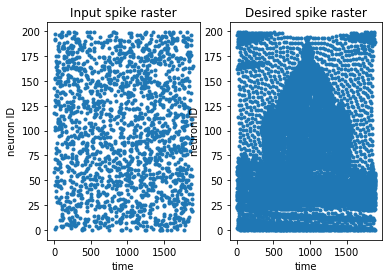

In [14]:
# showTD animation does not work in jupyter session
# snn.io.showTD(snn.io.spikeArrayToEvent(  input.reshape((1, Nin , -1)).cpu().data.numpy()))
# snn.io.showTD(snn.io.spikeArrayToEvent(desired.reshape((1, Nout, -1)).cpu().data.numpy()))
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(inTD.t, inTD.x, '.')
plt.title('Input spike raster')
plt.xlabel('time')
plt.ylabel('neuron ID')

plt.subplot(1, 2, 2)
plt.plot(desTD.t, desTD.x, '.')
plt.title('Desired spike raster')
plt.xlabel('time')
plt.ylabel('neuron ID')
plt.show()


# Run the network
* Run the network for 10000 epochs
* `bestNetwork` is stored for inferencing later

In [8]:
losslog = list()

for epoch in range(10000):
	output = net.forward(input)
	
	loss = error.spikeTime(output, desired)
	
	if epoch%10 == 0:	print('loss in epoch', epoch, ':', loss.cpu().data.numpy())
	losslog.append(loss.cpu().data.numpy())

	optimizer.zero_grad()
	loss.backward()
	optimizer.step()

	if epoch==0:
		minLoss = loss
		bestNet = net
	else:
		if loss < minLoss:
			minLoss = loss
			bestNet = net

	if loss < 1e-5:	break

loss in epoch 0 : 223909.14
loss in epoch 10 : 223909.14
loss in epoch 20 : 234708.83
loss in epoch 30 : 283094.94
loss in epoch 40 : 308074.8
loss in epoch 50 : 239665.83
loss in epoch 60 : 203188.84
loss in epoch 70 : 181538.27
loss in epoch 80 : 155541.92
loss in epoch 90 : 135178.75
loss in epoch 100 : 128820.86
loss in epoch 110 : 119681.84
loss in epoch 120 : 111884.17
loss in epoch 130 : 121109.51
loss in epoch 140 : 115753.18
loss in epoch 150 : 123803.625
loss in epoch 160 : 116661.81
loss in epoch 170 : 127331.3
loss in epoch 180 : 129419.12
loss in epoch 190 : 111402.5
loss in epoch 200 : 103428.76
loss in epoch 210 : 104777.92
loss in epoch 220 : 101208.84
loss in epoch 230 : 130030.05
loss in epoch 240 : 108983.305
loss in epoch 250 : 112235.94
loss in epoch 260 : 89975.69
loss in epoch 270 : 99561.1
loss in epoch 280 : 103925.69
loss in epoch 290 : 102933.75
loss in epoch 300 : 97369.625
loss in epoch 310 : 106328.67
loss in epoch 320 : 99262.445
loss in epoch 330 : 10355

loss in epoch 2740 : 74432.34
loss in epoch 2750 : 64863.36
loss in epoch 2760 : 62935.273
loss in epoch 2770 : 69630.47
loss in epoch 2780 : 69079.984
loss in epoch 2790 : 73354.58
loss in epoch 2800 : 71630.28
loss in epoch 2810 : 67451.69
loss in epoch 2820 : 69591.06
loss in epoch 2830 : 69687.06
loss in epoch 2840 : 83104.01
loss in epoch 2850 : 66275.984
loss in epoch 2860 : 65117.062
loss in epoch 2870 : 64430.277
loss in epoch 2880 : 64349.23
loss in epoch 2890 : 67360.92
loss in epoch 2900 : 67561.84
loss in epoch 2910 : 62487.742
loss in epoch 2920 : 67038.445
loss in epoch 2930 : 64269.062
loss in epoch 2940 : 73059.83
loss in epoch 2950 : 64534.63
loss in epoch 2960 : 71110.016
loss in epoch 2970 : 63490.695
loss in epoch 2980 : 93534.914
loss in epoch 2990 : 67409.83
loss in epoch 3000 : 62237.703
loss in epoch 3010 : 62984.2
loss in epoch 3020 : 68974.74
loss in epoch 3030 : 64675.97
loss in epoch 3040 : 60443.28
loss in epoch 3050 : 71076.79
loss in epoch 3060 : 63689.33

loss in epoch 5440 : 50784.33
loss in epoch 5450 : 52819.484
loss in epoch 5460 : 51098.8
loss in epoch 5470 : 48733.695
loss in epoch 5480 : 50783.984
loss in epoch 5490 : 50252.164
loss in epoch 5500 : 50623.336
loss in epoch 5510 : 52120.125
loss in epoch 5520 : 48462.273
loss in epoch 5530 : 47703.953
loss in epoch 5540 : 48957.883
loss in epoch 5550 : 52913.766
loss in epoch 5560 : 46913.285
loss in epoch 5570 : 50243.82
loss in epoch 5580 : 54583.375
loss in epoch 5590 : 54655.094
loss in epoch 5600 : 53667.992
loss in epoch 5610 : 50718.75
loss in epoch 5620 : 51114.156
loss in epoch 5630 : 52786.5
loss in epoch 5640 : 48643.258
loss in epoch 5650 : 51791.344
loss in epoch 5660 : 52818.965
loss in epoch 5670 : 47965.438
loss in epoch 5680 : 48973.484
loss in epoch 5690 : 47620.918
loss in epoch 5700 : 46752.883
loss in epoch 5710 : 52508.44
loss in epoch 5720 : 50575.65
loss in epoch 5730 : 50901.78
loss in epoch 5740 : 49336.11
loss in epoch 5750 : 52898.043
loss in epoch 5760 

loss in epoch 8140 : 36987.312
loss in epoch 8150 : 58335.508
loss in epoch 8160 : 44254.805
loss in epoch 8170 : 37843.812
loss in epoch 8180 : 45399.88
loss in epoch 8190 : 45646.97
loss in epoch 8200 : 52055.05
loss in epoch 8210 : 47897.67
loss in epoch 8220 : 52451.78
loss in epoch 8230 : 40337.535
loss in epoch 8240 : 45332.727
loss in epoch 8250 : 42371.844
loss in epoch 8260 : 48830.594
loss in epoch 8270 : 38242.152
loss in epoch 8280 : 40007.9
loss in epoch 8290 : 44750.047
loss in epoch 8300 : 44361.07
loss in epoch 8310 : 37645.85
loss in epoch 8320 : 42289.29
loss in epoch 8330 : 43913.582
loss in epoch 8340 : 44001.332
loss in epoch 8350 : 36142.945
loss in epoch 8360 : 44286.797
loss in epoch 8370 : 44406.97
loss in epoch 8380 : 38951.992
loss in epoch 8390 : 44680.484
loss in epoch 8400 : 45223.113
loss in epoch 8410 : 44757.97
loss in epoch 8420 : 38648.508
loss in epoch 8430 : 45261.67
loss in epoch 8440 : 37786.35
loss in epoch 8450 : 40336.6
loss in epoch 8460 : 424

## Inference using the best network

In [9]:
output = bestNet.forward(input)

## Plot the Results

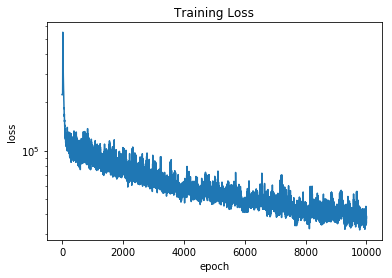

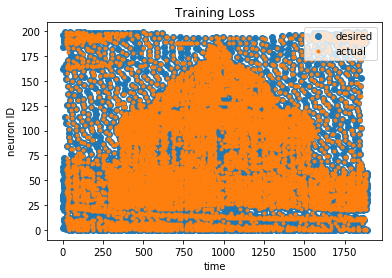

In [15]:
plt.figure(1)
plt.semilogy(losslog)
plt.title('Training Loss')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.figure(2)
desAER = np.argwhere(desired.reshape((Nout, Ns)).cpu().data.numpy() > 0)
outAER = np.argwhere(output.reshape((Nout, Ns)).cpu().data.numpy() > 0)
plt.plot(desAER[:, 1], desAER[:, 0], 'o', label='desired')
plt.plot(outAER[:, 1], outAER[:, 0], '.', label='actual')
plt.title('Training Loss')
plt.xlabel('time')
plt.ylabel('neuron ID')
plt.legend()

plt.show()